# Used car price/quality classification


- Isha shah
- Prince Kheni
- Tanay Dangaich
- Tarun Kaushik

## Import the required Libraries and load the data into Dataframe

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import catboost as ctb
import seaborn as sns
import matplotlib.pyplot as plt

#Model development and feature engineering libraries
from scipy import stats
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.contrib.wrapper import wrap

In [2]:
df=pd.read_csv("Cars Dataset.csv")
df1 = pd.read_csv("Cars Dataset.csv")

## Exploratory Data Analysis

In [3]:
#convert to int type
df.index.astype('int64')

RangeIndex(start=0, stop=12076, step=1)

In [4]:
#to check null values
df.isnull().sum()

YEAR            0
MAKE            0
MODEL           0
CONDITION       0
TRANSMISSION    0
CYLINDERS       0
FUEL            0
ODOMETER        0
ENGINE POWER    0
MILAGE          0
Price           0
dtype: int64

In [5]:
df.shape

(12076, 11)

### Data Visualization

In [8]:
ax = sns.countplot(x="MAKE",data=df)
ax.tick_params(axis='x', rotation=90)

In [9]:
sns.countplot(x="CYLINDERS",data=df)
ax.tick_params(axis='x', rotation=90)

<AxesSubplot:xlabel='FUEL', ylabel='count'>

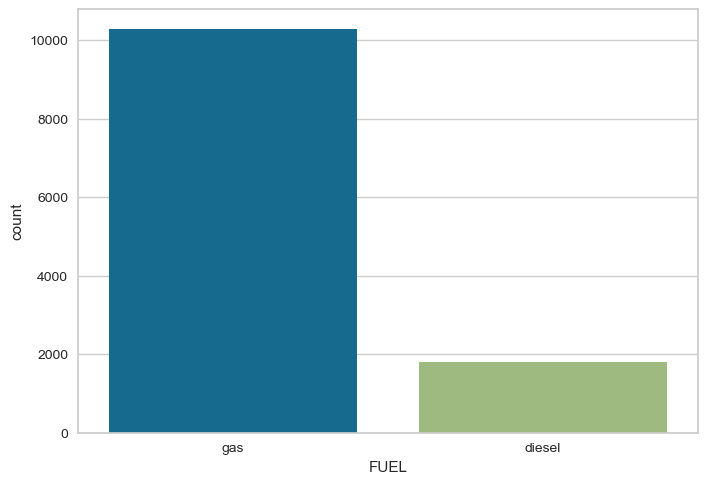

In [9]:
sns.countplot(x="FUEL",data=df)

<AxesSubplot:xlabel='ENGINE POWER', ylabel='count'>

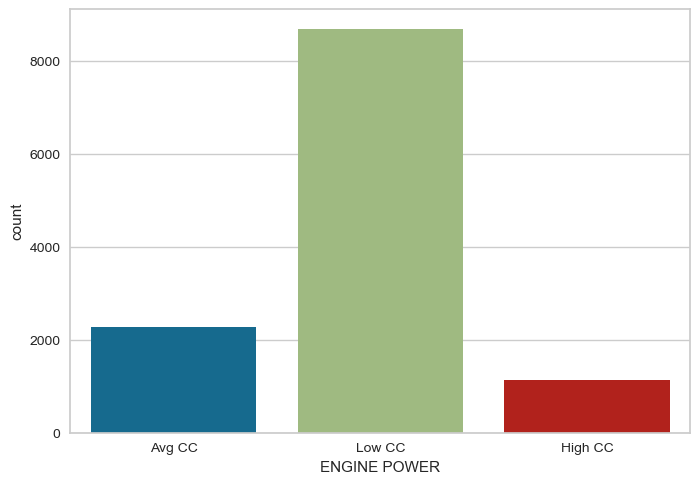

In [10]:
sns.countplot(x="ENGINE POWER",data=df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12076 entries, 0 to 12075
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YEAR          12076 non-null  int64 
 1   MAKE          12076 non-null  object
 2   MODEL         12076 non-null  object
 3   CONDITION     12076 non-null  object
 4   TRANSMISSION  12076 non-null  object
 5   CYLINDERS     12076 non-null  int64 
 6   FUEL          12076 non-null  object
 7   ODOMETER      12076 non-null  int64 
 8   ENGINE POWER  12076 non-null  object
 9   MILAGE        12076 non-null  int64 
 10  Price         12076 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.0+ MB


In [12]:
#count model for each car manufacturing company
df.MAKE.value_counts()

ford               2792
chevrolet          2143
ram                1003
toyota              791
gmc                 713
jeep                520
nissan              441
dodge               429
honda               414
bmw                 269
mercedes-benz       245
volkswagen          217
cadillac            208
subaru              206
hyundai             174
chrysler            166
buick               156
lexus               127
audi                122
mazda               120
kia                 113
lincoln              91
pontiac              90
volvo                90
infiniti             82
acura                71
rover                57
mitsubishi           48
jaguar               45
mercury              41
mini                 32
saturn               29
fiat                  9
ferrari               9
datsun                7
alfa-romeo            2
aston-martin          2
harley-davidson       1
hennessey             1
Name: MAKE, dtype: int64

## Data Preprocessing

There are few car company with very few records such as 1 or 2 records. So, We dropped those.

In [13]:
#deleted least valued data
df.drop(df[(df['MAKE'] == 'aston-martin') | (df['MAKE'] == 'alfa-romeo') | (df['MAKE'] == 'harley-davidson') | (df['MAKE'] == 'hennessey')].index, inplace=True)
df.reset_index(drop=True, inplace = True)
df.shape

(12070, 11)

In [14]:
#categorised milage column
def categorize(x):
    if (x >0 and x <= 10):
        return '0'
    if (x > 10 and x <= 20):
        return '1'
    if (x > 20 and x <= 30):
        return '2'
    if x > 30:
        return '3'
#applying the filter function to 'MILAGE' column 
df['category'] = df['MILAGE'].apply(categorize)

In [15]:
df.drop(df[(df['CONDITION'] == 1.0) & (df['Price'] != 0)].index, inplace=True)
df.reset_index(drop=True, inplace = True)
df.shape

(12070, 12)

In [16]:
# extracted car age 
df['Current Year'] = 2022
df['YEAR'] = df['Current Year'] - df['YEAR']
df.rename(columns = {'YEAR':'CAR_AGE'}, inplace = True)
df

,CAR_AGE,MAKE,MODEL,CONDITION,TRANSMISSION,CYLINDERS,FUEL,ODOMETER,ENGINE POWER,MILAGE,Price,category,Current Year
0,11,chevrolet,camaro,Excellent,Automatic,6,gas,12200,Avg CC,6,0,0,2022
1,10,chrysler,town & country,Excellent,Manual,6,gas,111000,Low CC,11,0,1,2022
2,13,jeep,liberty,Excellent,Manual,6,gas,68650,Low CC,49,0,3,2022
3,11,buick,lacrosse,Excellent,Manual,6,gas,123562,High CC,40,0,3,2022
4,14,chevrolet,cobalt,Excellent,Automatic,4,gas,138001,Avg CC,33,0,3,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12065,7,chevrolet,silverado,Excellent,Manual,8,diesel,170781,Low CC,48,1,3,2022
12066,4,toyota,tacoma,Excellent,Automatic,6,gas,9561,Low CC,37,1,3,2022
12067,5,ford,f-250 sd,Excellent,Manual,8,diesel,125780,Low CC,33,1,3,2022
12068,5,ram,1500 crew cab,Excellent,Manual,8,gas,21141,Low CC,37,1,3,2022


In [17]:
df.drop(df[(df['CAR_AGE']>20)].index, inplace = True)
df.reset_index(drop=True, inplace = True)
df.shape

(11078, 13)

In [18]:
# calculated avg odometer to get insights of odometer
df['Avg_odometer'] = df['ODOMETER'].div(df['CAR_AGE']).round(2)

In [19]:
df.drop(df[(df['Avg_odometer']<100) & (df['ODOMETER']<100)].index, inplace = True)
df.reset_index(drop=True, inplace = True)
df.shape

(11006, 14)

In [20]:
df

,CAR_AGE,MAKE,MODEL,CONDITION,TRANSMISSION,CYLINDERS,FUEL,ODOMETER,ENGINE POWER,MILAGE,Price,category,Current Year,Avg_odometer
0,11,chevrolet,camaro,Excellent,Automatic,6,gas,12200,Avg CC,6,0,0,2022,1109.09
1,10,chrysler,town & country,Excellent,Manual,6,gas,111000,Low CC,11,0,1,2022,11100.00
2,13,jeep,liberty,Excellent,Manual,6,gas,68650,Low CC,49,0,3,2022,5280.77
3,11,buick,lacrosse,Excellent,Manual,6,gas,123562,High CC,40,0,3,2022,11232.91
4,14,chevrolet,cobalt,Excellent,Automatic,4,gas,138001,Avg CC,33,0,3,2022,9857.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11001,7,chevrolet,silverado,Excellent,Manual,8,diesel,170781,Low CC,48,1,3,2022,24397.29
11002,4,toyota,tacoma,Excellent,Automatic,6,gas,9561,Low CC,37,1,3,2022,2390.25
11003,5,ford,f-250 sd,Excellent,Manual,8,diesel,125780,Low CC,33,1,3,2022,25156.00
11004,5,ram,1500 crew cab,Excellent,Manual,8,gas,21141,Low CC,37,1,3,2022,4228.20


Also, we have few columns with categorical values, to convert it into numerical(label) using `Label Encoder()`

In [21]:
#encoded the categorical value
Encoder = preprocessing.LabelEncoder()
df['MAKE'] = Encoder.fit_transform(df['MAKE'])
df['MODEL'] = Encoder.fit_transform(df['MODEL'])
df['FUEL'] = Encoder.fit_transform(df['FUEL'])
df['TRANSMISSION'] = Encoder.fit_transform(df['TRANSMISSION'])
df['CONDITION'] = Encoder.fit_transform(df['CONDITION'])
df['ENGINE POWER'] = Encoder.fit_transform(df['ENGINE POWER'])

In [22]:
df.drop('Current Year', inplace=True, axis =1)

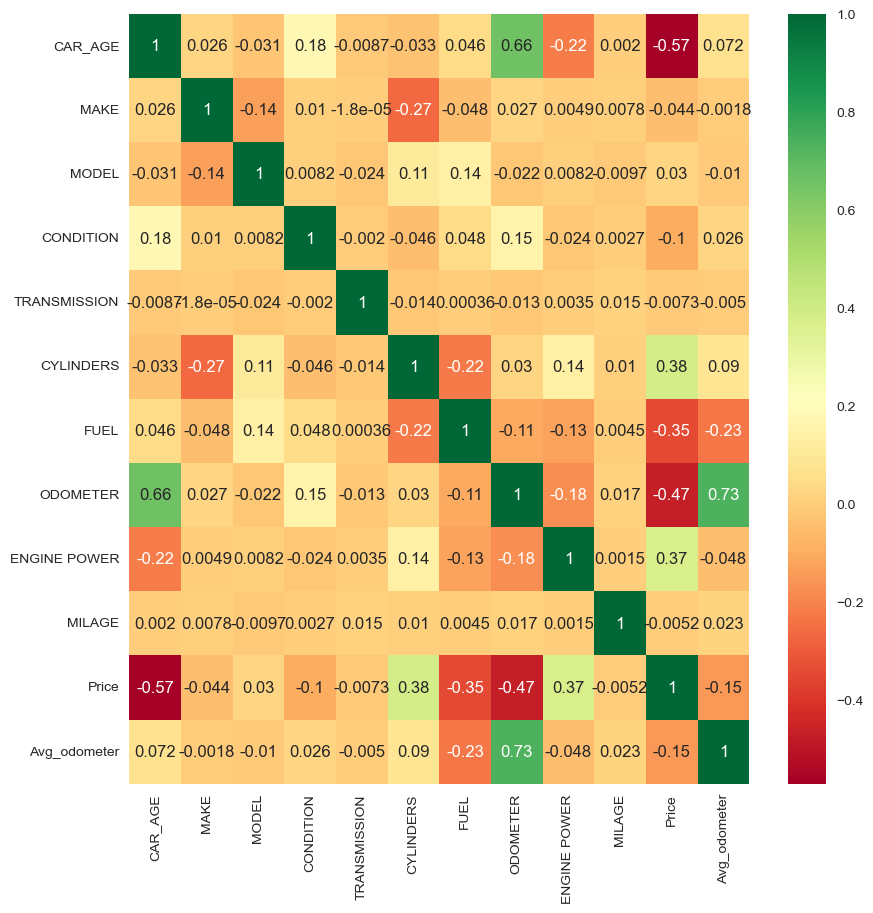

In [23]:
# to get correlation between each feature
x = df.iloc[:,1:10]  
y = df.iloc[:,10]    
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

array([[<AxesSubplot:title={'center':'ODOMETER'}>,
        <AxesSubplot:title={'center':'Avg_odometer'}>],
       [<AxesSubplot:title={'center':'MODEL'}>,
        <AxesSubplot:title={'center':'CAR_AGE'}>]], dtype=object)

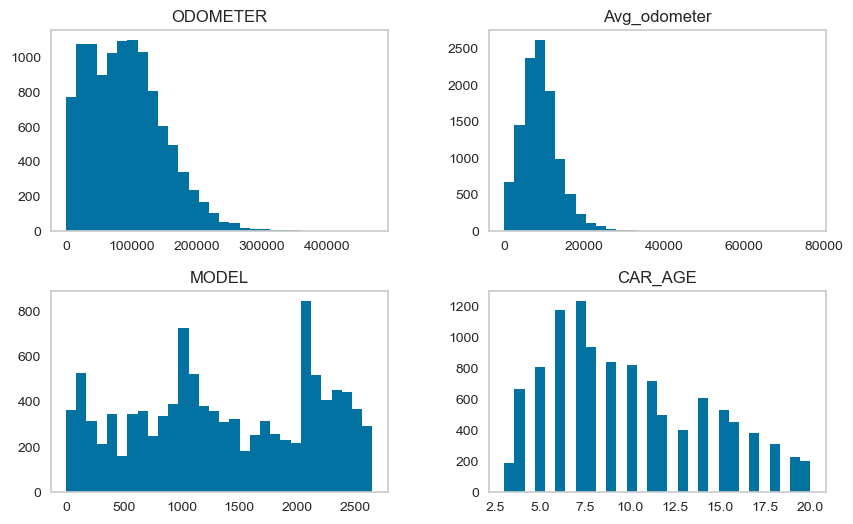

In [24]:
#to get skewed data visualization
df.hist(column =['ODOMETER', 'Avg_odometer','MODEL','CAR_AGE'], grid=False,figsize=(10, 6),bins=30)

In [25]:
df['ODOMETER'].skew()

0.7034498727828956

In [26]:
df.insert(len(df.columns), 'Car_Age', stats.boxcox(df['CAR_AGE'])[0])
df.insert(len(df.columns), 'odometer',stats.boxcox(df['ODOMETER'])[0])

array([[<AxesSubplot:title={'center':'odometer'}>,
        <AxesSubplot:title={'center':'ODOMETER'}>],
       [<AxesSubplot:title={'center':'CAR_AGE'}>,
        <AxesSubplot:title={'center':'Car_Age'}>]], dtype=object)

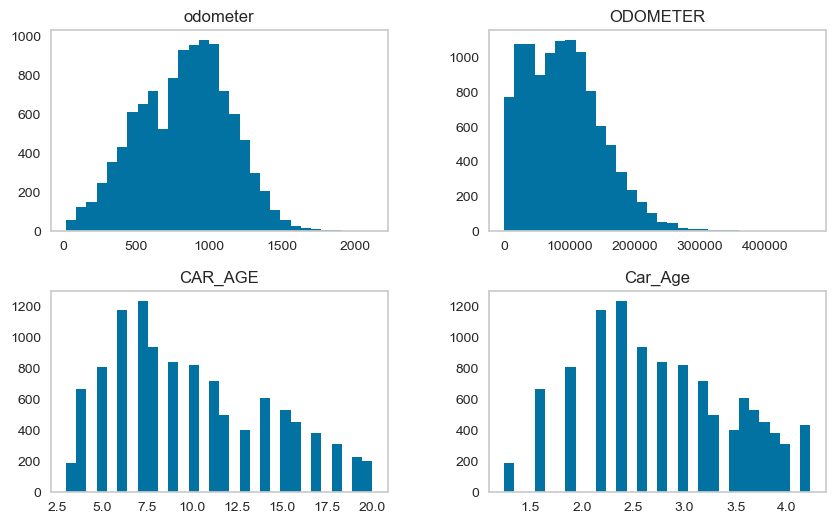

In [27]:
#,'CAR_AGE', 'A_Sqrt'
df.hist(column =['odometer', 'ODOMETER','CAR_AGE','Car_Age'], grid=False,figsize=(10, 6),bins=30)

In [28]:
df

,CAR_AGE,MAKE,MODEL,CONDITION,TRANSMISSION,CYLINDERS,FUEL,ODOMETER,ENGINE POWER,MILAGE,Price,category,Avg_odometer,Car_Age,odometer
0,11,5,556,0,0,6,1,12200,0,6,0,0,1109.09,3.150405,294.225378
1,10,6,2383,0,1,6,1,111000,2,11,0,1,11100.00,2.991249,971.838255
2,13,16,1554,0,1,6,1,68650,2,49,0,3,5280.77,3.437473,749.618581
3,11,3,1524,0,1,6,1,123562,1,40,0,3,11232.91,3.150405,1029.778502
4,14,5,657,0,0,4,1,138001,0,33,0,3,9857.21,3.568210,1093.115870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11001,7,5,2105,0,1,8,0,170781,2,48,1,3,24397.29,2.424167,1226.442741
11002,4,31,2308,0,0,6,1,9561,2,37,1,3,2390.25,1.618759,257.765199
11003,5,10,1099,0,1,8,0,125780,2,33,1,3,25156.00,1.928176,1039.721486
11004,5,27,28,0,1,8,1,21141,2,37,1,3,4228.20,1.928176,396.377802


In [29]:
df.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
CAR_AGE,0.518973,-0.737841
MAKE,0.650757,-0.951175
MODEL,-0.082667,-1.202719
CONDITION,8.193576,65.146519
TRANSMISSION,0.395729,-1.843734
CYLINDERS,-0.338991,-1.218157
FUEL,-1.889630,1.570985
ODOMETER,0.703450,0.662567
ENGINE POWER,-1.274556,-0.162873
MILAGE,-0.008098,-1.191430


In [30]:
#dropped and renamed unwated and wanted columns
df.drop(['ODOMETER','Avg_odometer','MILAGE', 'CONDITION', 'CAR_AGE'], inplace=True, axis=1)
df = df.rename({'odometer': 'ODOMETER','category':'MILEAGE', 'Car_Age' : 'CAR_AGE'}, axis=1)

In [31]:
#convert mileage type to int type
df['MILEAGE']=df['MILEAGE'].astype('int64')

In [32]:
df = df[['CAR_AGE', 'MAKE', 'MODEL', 'TRANSMISSION', 'CYLINDERS', 'FUEL', 'ENGINE POWER', 'MILEAGE', 'ODOMETER', 'Price']]

## Spliting the 70% of data into train data & 30% of data into test data

In [33]:
X = df.iloc[:,:9]
y = df.iloc[:,9]

In [34]:
#
train_X,test_X,train_Y,test_Y = train_test_split(X,y, test_size=0.3)

## Feature Selection & Importance

In [35]:
rf = RandomForestClassifier()
rf.fit(train_X, train_Y)

RandomForestClassifier()

<AxesSubplot:>

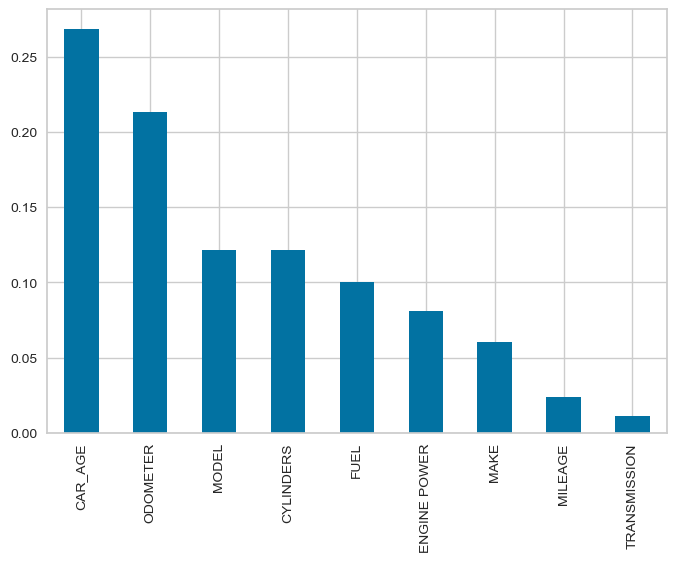

In [36]:
rf.feature_importances_

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='bar')

## Model Development & Execution
- `K-Nearest Neighbor`
- `Decision Tree`
- `Cat Boost Classifier`
- `Light Gradient Boosting`

### (1) K-Nearest Neighbor

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k = 3 


Accuracy Score is:  0.8419139915202908



classification_report of data after Knn applied: 
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      1888
           1       0.80      0.83      0.82      1347
           2       0.47      0.30      0.36        67

    accuracy                           0.84      3302
   macro avg       0.72      0.67      0.68      3302
weighted avg       0.84      0.84      0.84      3302
 


Confusion Matrix of data predicted 
 [[1639  244    5]
 [ 208 1121   18]
 [  10   37   20]] 




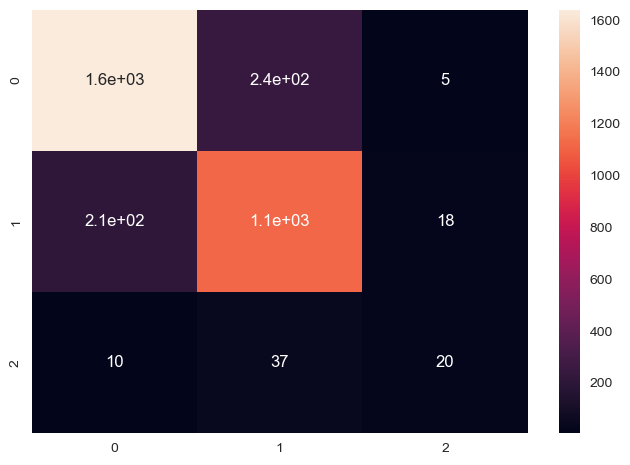

C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


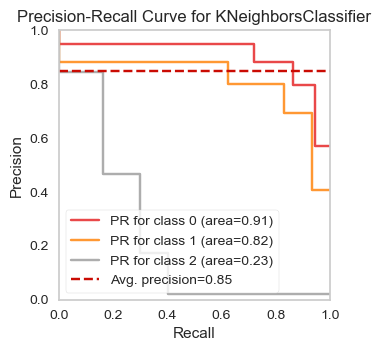

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k = 5 


Accuracy Score is:  0.8276801938219261



classification_report of data after Knn applied: 
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1888
           1       0.77      0.83      0.80      1347
           2       0.42      0.21      0.28        67

    accuracy                           0.83      3302
   macro avg       0.69      0.63      0.65      3302
weighted avg       0.83      0.83      0.83      3302
 


Confusion Matrix of data predicted 
 [[1595  287    6]
 [ 210 1124   13]
 [   9   44   14]] 




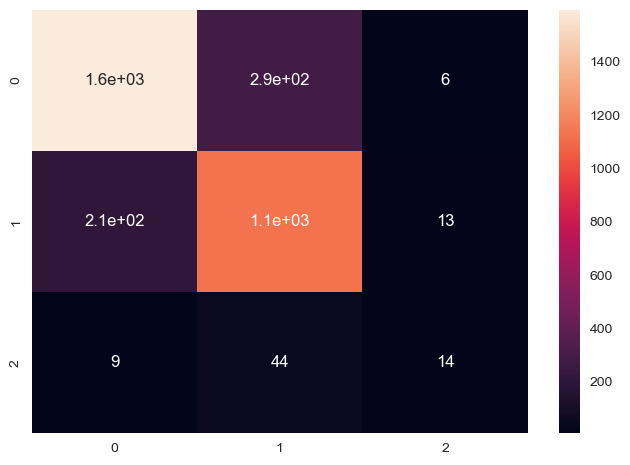

C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


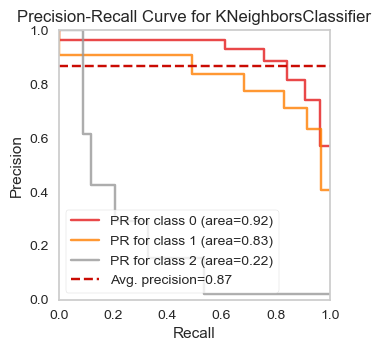

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k = 10 


Accuracy Score is:  0.8119321623258631



classification_report of data after Knn applied: 
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      1888
           1       0.76      0.81      0.78      1347
           2       0.43      0.09      0.15        67

    accuracy                           0.81      3302
   macro avg       0.68      0.58      0.59      3302
weighted avg       0.81      0.81      0.81      3302
 


Confusion Matrix of data predicted 
 [[1588  297    3]
 [ 255 1087    5]
 [  11   50    6]] 




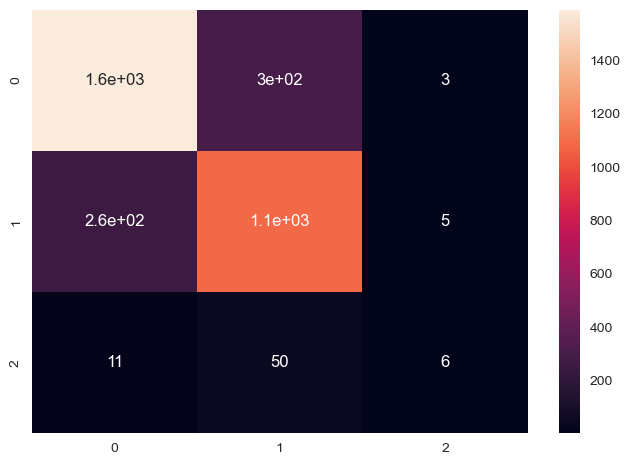

C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


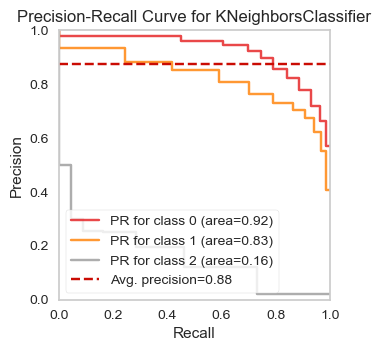

In [37]:
lst = [3,5,10]
pred = []
for i in range(len(lst)):
    knn = KNeighborsClassifier(n_neighbors=lst[i])
    k_nn = knn.fit(train_X, train_Y)
  
 # Predict on dataset which model has not seen before
    y_predict = knn.predict(test_X)
   
    print('k =',lst[i],'\n\n')
    print('Accuracy Score is: ',accuracy_score(test_Y, y_predict)) #TP+FN/TP+TF+FP+FN
    print('\n\n\nclassification_report of data after Knn applied: \n',classification_report(test_Y, y_predict),'\n\n') 
    #precision = TP/TP+FP & recall = TP/TP+TN & f1_score = harmonic_mean of pre and recall 
    print('Confusion Matrix of data predicted \n',confusion_matrix(test_Y, y_predict),'\n\n') #TP,TN,FP,FN,
    data = confusion_matrix(test_Y, y_predict)
    df_cm = pd.DataFrame(data, columns=np.unique(test_Y), index = np.unique(test_Y))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    ax = sns.heatmap(pd.DataFrame(confusion_matrix(test_Y, y_predict)), annot=True)
    plt.show()
    
    viz = PrecisionRecallCurve(k_nn, per_class=True, cmap="Set1", size = (350,350))
    viz.fit(train_X, train_Y,)
    viz.score(test_X, test_Y)
    viz.show()

### (2) Decision Tree

In [38]:
dtc_initiate = DecisionTreeClassifier(criterion = 'entropy', random_state = 0) 
#max_depth can also be given to get particular no. of splits
dt = dtc_initiate.fit(train_X, train_Y)

In [39]:
#predict the test results
y_pred = dtc_initiate.predict(test_X)

In [40]:
print('Accuracy for Test dataset: {0:0.4f}'.format(accuracy_score(test_Y, y_pred)))
print('Confusion Metrics: \n\n', confusion_matrix(test_Y, y_pred))
print('Classification report:\n\n', classification_report(test_Y, y_pred))

Accuracy for Test dataset: 0.8988
Confusion Metrics: 

 [[1753  132    3]
 [ 138 1177   32]
 [   0   29   38]]
Classification report:

               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1888
           1       0.88      0.87      0.88      1347
           2       0.52      0.57      0.54        67

    accuracy                           0.90      3302
   macro avg       0.78      0.79      0.78      3302
weighted avg       0.90      0.90      0.90      3302



<AxesSubplot:>

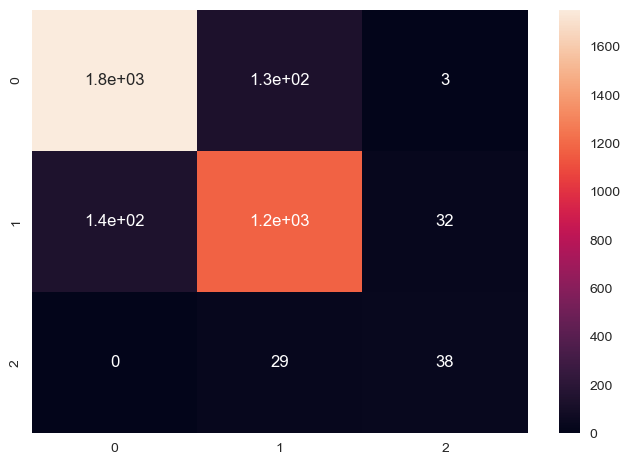

In [41]:
sns.heatmap(pd.DataFrame(confusion_matrix(test_Y, y_pred)), annot=True)

C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


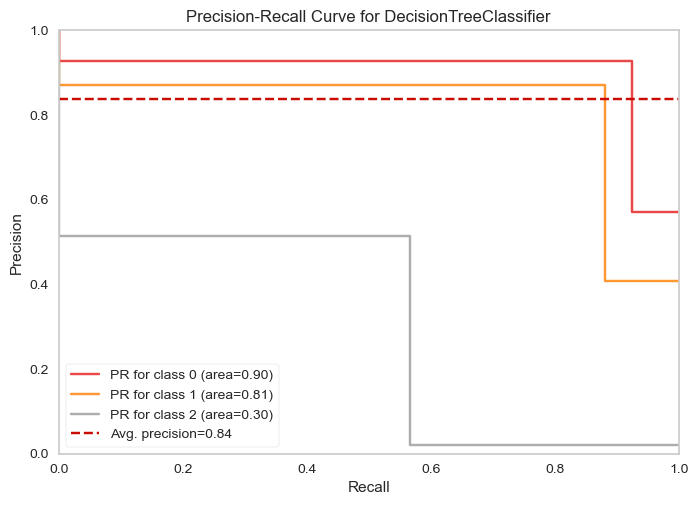

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [42]:
viz = PrecisionRecallCurve(dt, per_class=True, 
cmap="Set1"
)
viz.fit(train_X, train_Y,)
viz.score(test_X, test_Y)
viz.show()

### (3) Cat Boost Classifier

In [43]:
CBR = ctb.CatBoostClassifier()

cbr = CBR.fit(train_X, train_Y)

pred_Y = CBR.predict(test_X)

Learning rate set to 0.08781
0:	learn: 0.9907829	total: 144ms	remaining: 2m 24s
1:	learn: 0.9010207	total: 163ms	remaining: 1m 21s
2:	learn: 0.8288097	total: 184ms	remaining: 1m 1s
3:	learn: 0.7674128	total: 209ms	remaining: 52.1s
4:	learn: 0.7168362	total: 235ms	remaining: 46.8s
5:	learn: 0.6713711	total: 257ms	remaining: 42.6s
6:	learn: 0.6329274	total: 276ms	remaining: 39.2s
7:	learn: 0.5976349	total: 294ms	remaining: 36.5s
8:	learn: 0.5661423	total: 312ms	remaining: 34.4s
9:	learn: 0.5393485	total: 331ms	remaining: 32.7s
10:	learn: 0.5155222	total: 349ms	remaining: 31.3s
11:	learn: 0.4960425	total: 367ms	remaining: 30.2s
12:	learn: 0.4760785	total: 386ms	remaining: 29.3s
13:	learn: 0.4587800	total: 404ms	remaining: 28.5s
14:	learn: 0.4436327	total: 430ms	remaining: 28.2s
15:	learn: 0.4291672	total: 452ms	remaining: 27.8s
16:	learn: 0.4166605	total: 466ms	remaining: 26.9s
17:	learn: 0.4051368	total: 476ms	remaining: 26s
18:	learn: 0.3974092	total: 484ms	remaining: 25s
19:	learn: 0.3

168:	learn: 0.2137688	total: 2.29s	remaining: 11.3s
169:	learn: 0.2132075	total: 2.31s	remaining: 11.3s
170:	learn: 0.2127965	total: 2.32s	remaining: 11.3s
171:	learn: 0.2123819	total: 2.33s	remaining: 11.2s
172:	learn: 0.2121702	total: 2.34s	remaining: 11.2s
173:	learn: 0.2118596	total: 2.35s	remaining: 11.2s
174:	learn: 0.2115552	total: 2.37s	remaining: 11.2s
175:	learn: 0.2113225	total: 2.38s	remaining: 11.1s
176:	learn: 0.2109272	total: 2.39s	remaining: 11.1s
177:	learn: 0.2106903	total: 2.4s	remaining: 11.1s
178:	learn: 0.2103052	total: 2.41s	remaining: 11.1s
179:	learn: 0.2099089	total: 2.42s	remaining: 11s
180:	learn: 0.2097249	total: 2.44s	remaining: 11s
181:	learn: 0.2093024	total: 2.44s	remaining: 11s
182:	learn: 0.2090043	total: 2.46s	remaining: 11s
183:	learn: 0.2087588	total: 2.47s	remaining: 10.9s
184:	learn: 0.2082781	total: 2.48s	remaining: 10.9s
185:	learn: 0.2080953	total: 2.49s	remaining: 10.9s
186:	learn: 0.2079000	total: 2.5s	remaining: 10.9s
187:	learn: 0.2077190	

331:	learn: 0.1729994	total: 4.18s	remaining: 8.42s
332:	learn: 0.1727727	total: 4.2s	remaining: 8.41s
333:	learn: 0.1723768	total: 4.21s	remaining: 8.4s
334:	learn: 0.1721649	total: 4.22s	remaining: 8.38s
335:	learn: 0.1720211	total: 4.23s	remaining: 8.37s
336:	learn: 0.1718819	total: 4.25s	remaining: 8.36s
337:	learn: 0.1716521	total: 4.26s	remaining: 8.35s
338:	learn: 0.1713844	total: 4.28s	remaining: 8.34s
339:	learn: 0.1713108	total: 4.29s	remaining: 8.33s
340:	learn: 0.1711443	total: 4.31s	remaining: 8.33s
341:	learn: 0.1709678	total: 4.32s	remaining: 8.32s
342:	learn: 0.1707425	total: 4.33s	remaining: 8.3s
343:	learn: 0.1705617	total: 4.35s	remaining: 8.29s
344:	learn: 0.1704597	total: 4.36s	remaining: 8.29s
345:	learn: 0.1702535	total: 4.38s	remaining: 8.28s
346:	learn: 0.1701353	total: 4.4s	remaining: 8.28s
347:	learn: 0.1699429	total: 4.42s	remaining: 8.29s
348:	learn: 0.1698019	total: 4.44s	remaining: 8.28s
349:	learn: 0.1695674	total: 4.45s	remaining: 8.26s
350:	learn: 0.16

493:	learn: 0.1485165	total: 6.27s	remaining: 6.42s
494:	learn: 0.1483773	total: 6.29s	remaining: 6.41s
495:	learn: 0.1482502	total: 6.3s	remaining: 6.4s
496:	learn: 0.1480946	total: 6.31s	remaining: 6.39s
497:	learn: 0.1479265	total: 6.33s	remaining: 6.38s
498:	learn: 0.1478151	total: 6.34s	remaining: 6.36s
499:	learn: 0.1477131	total: 6.35s	remaining: 6.35s
500:	learn: 0.1476416	total: 6.36s	remaining: 6.33s
501:	learn: 0.1475315	total: 6.37s	remaining: 6.32s
502:	learn: 0.1474165	total: 6.38s	remaining: 6.3s
503:	learn: 0.1472876	total: 6.39s	remaining: 6.29s
504:	learn: 0.1470133	total: 6.4s	remaining: 6.28s
505:	learn: 0.1469118	total: 6.42s	remaining: 6.26s
506:	learn: 0.1467990	total: 6.43s	remaining: 6.25s
507:	learn: 0.1466962	total: 6.44s	remaining: 6.24s
508:	learn: 0.1466652	total: 6.45s	remaining: 6.22s
509:	learn: 0.1465069	total: 6.46s	remaining: 6.21s
510:	learn: 0.1464001	total: 6.48s	remaining: 6.2s
511:	learn: 0.1463528	total: 6.49s	remaining: 6.19s
512:	learn: 0.146

661:	learn: 0.1292276	total: 8.34s	remaining: 4.26s
662:	learn: 0.1290775	total: 8.36s	remaining: 4.25s
663:	learn: 0.1289450	total: 8.37s	remaining: 4.23s
664:	learn: 0.1288657	total: 8.38s	remaining: 4.22s
665:	learn: 0.1287565	total: 8.39s	remaining: 4.21s
666:	learn: 0.1286511	total: 8.4s	remaining: 4.2s
667:	learn: 0.1285317	total: 8.41s	remaining: 4.18s
668:	learn: 0.1284370	total: 8.43s	remaining: 4.17s
669:	learn: 0.1282938	total: 8.44s	remaining: 4.15s
670:	learn: 0.1281858	total: 8.45s	remaining: 4.14s
671:	learn: 0.1280717	total: 8.46s	remaining: 4.13s
672:	learn: 0.1279724	total: 8.46s	remaining: 4.11s
673:	learn: 0.1278999	total: 8.48s	remaining: 4.1s
674:	learn: 0.1277732	total: 8.49s	remaining: 4.09s
675:	learn: 0.1277245	total: 8.51s	remaining: 4.08s
676:	learn: 0.1276228	total: 8.52s	remaining: 4.07s
677:	learn: 0.1274889	total: 8.54s	remaining: 4.06s
678:	learn: 0.1273746	total: 8.55s	remaining: 4.04s
679:	learn: 0.1273237	total: 8.56s	remaining: 4.03s
680:	learn: 0.1

826:	learn: 0.1140628	total: 10.4s	remaining: 2.17s
827:	learn: 0.1140096	total: 10.4s	remaining: 2.16s
828:	learn: 0.1139407	total: 10.4s	remaining: 2.15s
829:	learn: 0.1139046	total: 10.4s	remaining: 2.13s
830:	learn: 0.1138321	total: 10.4s	remaining: 2.12s
831:	learn: 0.1137767	total: 10.4s	remaining: 2.11s
832:	learn: 0.1136974	total: 10.5s	remaining: 2.1s
833:	learn: 0.1136496	total: 10.5s	remaining: 2.08s
834:	learn: 0.1135881	total: 10.5s	remaining: 2.07s
835:	learn: 0.1135234	total: 10.5s	remaining: 2.06s
836:	learn: 0.1134220	total: 10.5s	remaining: 2.05s
837:	learn: 0.1133732	total: 10.5s	remaining: 2.03s
838:	learn: 0.1132926	total: 10.5s	remaining: 2.02s
839:	learn: 0.1132590	total: 10.5s	remaining: 2.01s
840:	learn: 0.1132007	total: 10.6s	remaining: 2s
841:	learn: 0.1131355	total: 10.6s	remaining: 1.98s
842:	learn: 0.1130665	total: 10.6s	remaining: 1.97s
843:	learn: 0.1129877	total: 10.6s	remaining: 1.96s
844:	learn: 0.1129083	total: 10.6s	remaining: 1.94s
845:	learn: 0.11

In [44]:
print(accuracy_score(pred_Y, test_Y))
print('Confusion Metrics: \n\n', confusion_matrix(test_Y,pred_Y))
print('Classification report\n', classification_report(test_Y,pred_Y))

0.9267110841913991
Confusion Metrics: 

 [[1779  109    0]
 [  90 1250    7]
 [   0   36   31]]
Classification report
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1888
           1       0.90      0.93      0.91      1347
           2       0.82      0.46      0.59        67

    accuracy                           0.93      3302
   macro avg       0.89      0.78      0.82      3302
weighted avg       0.93      0.93      0.93      3302



<AxesSubplot:>

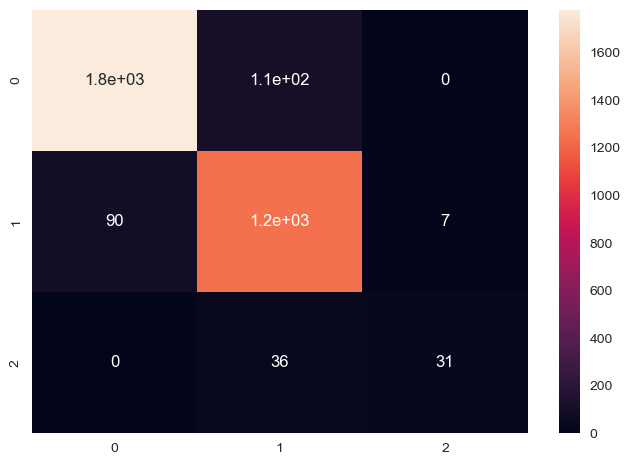

In [45]:
sns.heatmap(pd.DataFrame(confusion_matrix(test_Y,pred_Y)), annot=True)

### (4) Light Gradient Boosting (LGB)

In [46]:
lgb = LGBMClassifier()
model = lgb.fit(train_X, train_Y)
lgb_pred = lgb.predict(test_X)
print('Accuracy Score is: ',accuracy_score(test_Y, lgb_pred))
print('\n\n\nclassification_report of data after Knn applied: \n',classification_report(test_Y, lgb_pred),'\n\n') 
print('Confusion Matrix of data predicted \n',confusion_matrix(test_Y, lgb_pred),'\n\n')

Accuracy Score is:  0.9339794064203513



classification_report of data after Knn applied: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1888
           1       0.90      0.94      0.92      1347
           2       0.84      0.57      0.68        67

    accuracy                           0.93      3302
   macro avg       0.90      0.82      0.85      3302
weighted avg       0.93      0.93      0.93      3302
 


Confusion Matrix of data predicted 
 [[1776  111    1]
 [  71 1270    6]
 [   0   29   38]] 




<AxesSubplot:>

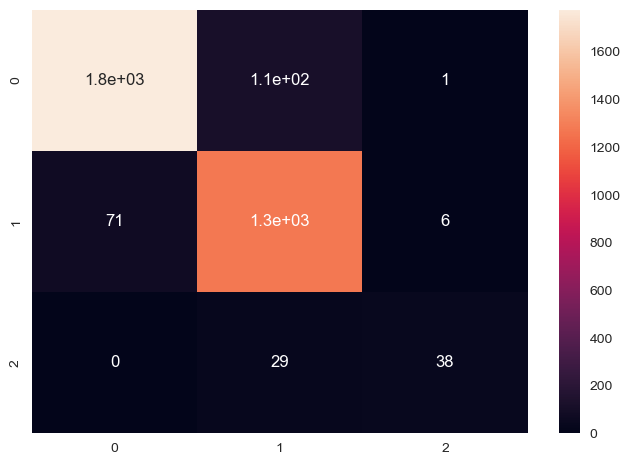

In [47]:
sns.heatmap(pd.DataFrame(confusion_matrix(test_Y, lgb_pred)), annot=True)

C:\Users\hp\anaconda3\lib\site-packages\yellowbrick\classifier\prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


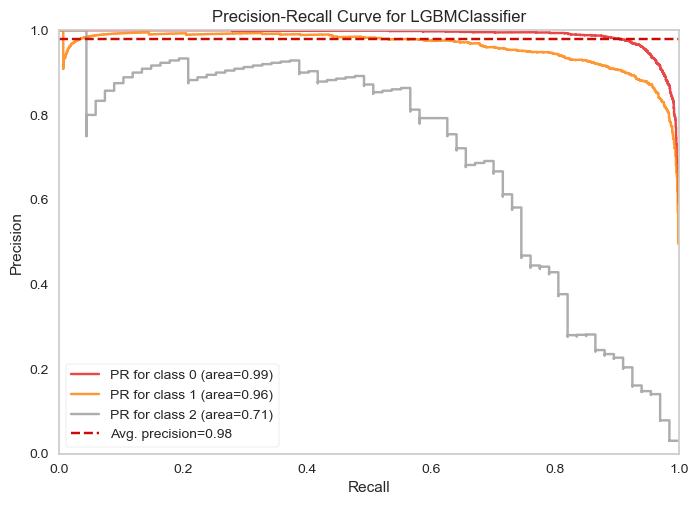

<AxesSubplot:title={'center':'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [48]:
viz = PrecisionRecallCurve(model, per_class=True, 
cmap="Set1"
)
viz.fit(train_X, train_Y,)
viz.score(test_X, test_Y)
viz.show()